# Game
本專案的目的是利用手部辨識技術，判別使用者是否正在使用Xbox搖桿進行嚴肅遊戲的訓練。辨識過程分為兩個主要步驟：

1. **時間序列分析**：首先從收集到的資料中，辨識出使用者正在進行遊戲的時間段，聚焦於符合使用者進行遊戲操作的時間區塊。
2. **按鈕操作次數的辨識**：接著利用時間序列中的峰值，計算出使用者在遊戲過程中按下搖桿按鈕的次數。

目前的數據僅來自一位使用者，共參與了7種不同的嚴肅遊戲。數據來源為Apple Watch，並且每秒收集100筆資料，總計64692筆。此數據將用於訓練模型，以達到準確辨識和計算的目的，為未來的多使用者、不同裝置擴展做準備。

In [6]:
import os
import csv

# 指定要查詢的路徑
path = 'data/Game'

csv_file_count = 0
total_rows = 0

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            csv_file_count += 1
            csv_file_path = os.path.join(root, file)
            with open(csv_file_path, 'r', encoding='utf-8') as f:
                reader = csv.reader(f)
                row_count = sum(1 for row in reader)
                total_rows += row_count

print(f'CSV檔案數量: {csv_file_count}')
print(f'總資料筆數: {total_rows}')


CSV檔案數量: 7
總資料筆數: 64692


## 模型的訓練寫在 aw_train函數中 使用寫在 detect_action_segments_with_changepoint_voting函數中

In [3]:
import aw_write_model
from aw_write_model import aw_train, detect_action_segments_with_changepoint_voting

In [31]:
all_variables = ['GravityX', 'GravityY', 'GravityZ', 'UserAccelerationX', 'UserAccelerationY', 'UserAccelerationZ', 'RotationRateX', 'RotationRateY', 'RotationRateZ', 'AttitudeRoll', 'AttitudePitch', 'AttitudeYaw']
part_variables = ['UserAccelerationX', 'UserAccelerationY', 'UserAccelerationZ']


通過`detect_action_segments_with_changepoint_voting`函數來辨識使用者是否在進行遊戲操作，並排除干擾噪聲。以下是這些參數與設計的重點：

1. **數據區段分辨與行為辨識**：該函數分析測試者資料，辨識遊戲操作時間段，並將其分為"Game"和"unknown"兩個標籤。在這段數據中，模型成功地將遊戲操作占比辨識為70.56%，未知行為占比為29.44%。

2. **平滑標籤 (Smooth Labels)**：為了避免短暫、突兀的異常訊號，平滑標籤的設計使模型能過濾掉低於指定長度的小噪聲，從而讓分類更加連貫。`smooth_labels=True`設定了啟用平滑功能，而`min_action_length=100`則設定了最小行為長度，將短暫的雜訊從結果中去除，以提高辨識的準確度。

3. **動作模型文件夾**：參數`model_dirs`指定了模型文件夾列表，確保模型可從正確的資料來源中載入，這裡將動作模型文件夾指定為`['saved_models/Game']`。

4. **數據讀取與儲存**：代碼中使用了測試數據路徑`path = 'test/Game/chunhao8_combined.csv'`，並且提供了選項將最終預測結果儲存至文件中。通過在數據集中新增`FinalPrediction`欄位，預測結果可以輸出至一個新CSV文件中，方便後續分析和檢查。



Game 占比: 96.61%
unknown 占比: 3.39%


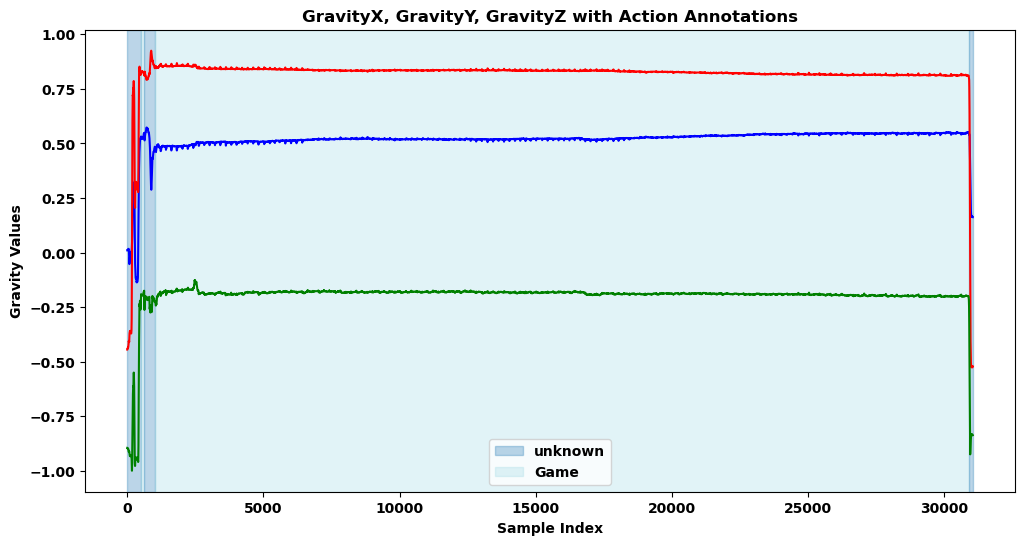

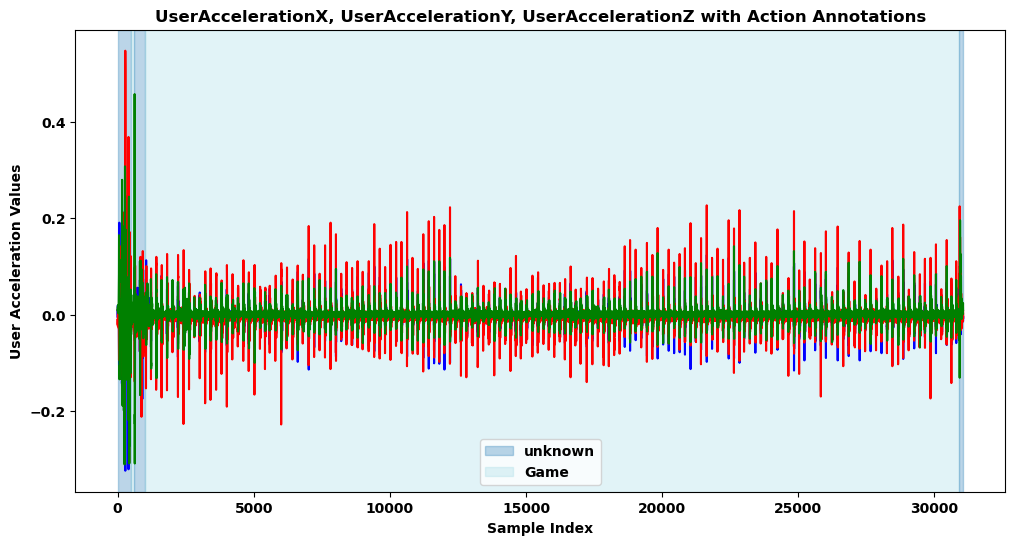

In [32]:
# 定義模型文件夾列表
model_dirs = ['saved_models/Game']  # 添加您的動作模型文件夾

# 讀取數據
path = 'data/20241102LeftHandFiveMin_combined.csv'

pre = detect_action_segments_with_changepoint_voting(file_path =  path,
                                                     model_dirs = model_dirs,
                                                     min_action_length=100,
                                                     variables = part_variables,
                                                     smooth_labels=False,
                                                     show_image=True)

# 如果需要，您可以將最終預測結果保存到文件中
# data = pd.read_csv(path)
# data['FinalPrediction'] = final_predictions
# data.to_csv('output_with_predictions.csv', index=False)


在成功區分出使用者進行遊戲的時間序列後，接下來針對該段資料進行峰值辨識，以精確計算搖桿按鈕的按壓次數。以下是該過程的詳細步驟：

1. **單一軸向峰值檢測**：針對三個加速度變數 `UserAccelerationX`、`UserAccelerationY` 和 `UserAccelerationZ`，分別進行峰值辨識。這樣的設計可以確保在各方向上捕捉到使用者的移動幅度，並從各軸的數據中提取潛在的按壓行為。

2. **峰值間距設定**：為了避免因連續峰值而誤判按鈕按壓次數，每個軸向的峰值間隔設定為最小50筆資料，確保每個峰值代表一次獨立的按壓動作。這樣可以有效降低連續偵測到的峰值導致的按壓次數重複計算的問題。

3. **重疊峰值合併**：最後，將來自不同軸向的峰值依時間順序合併，並將間隔小於50筆資料的重疊峰值視為同一次按壓操作。這樣的合併策略可以減少同一按壓動作在不同軸向上多次出現的情況，進一步提高按壓次數的辨識準確度。

這樣的峰值偵測與合併策略，結合先前的時間序列分析，有助於精確計算使用者在遊戲過程中的按壓次數，並排除潛在的數據雜訊，達到更真實的行為辨識結果。

C:\Users\B20770\AppData\Local\Temp\ipykernel_6108\3701771307.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\B20770\AppData\Local\Temp\ipykernel_6108\3701771307.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("peaks.png")
C:\ProgramData\anaconda3\envs\ADHD\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


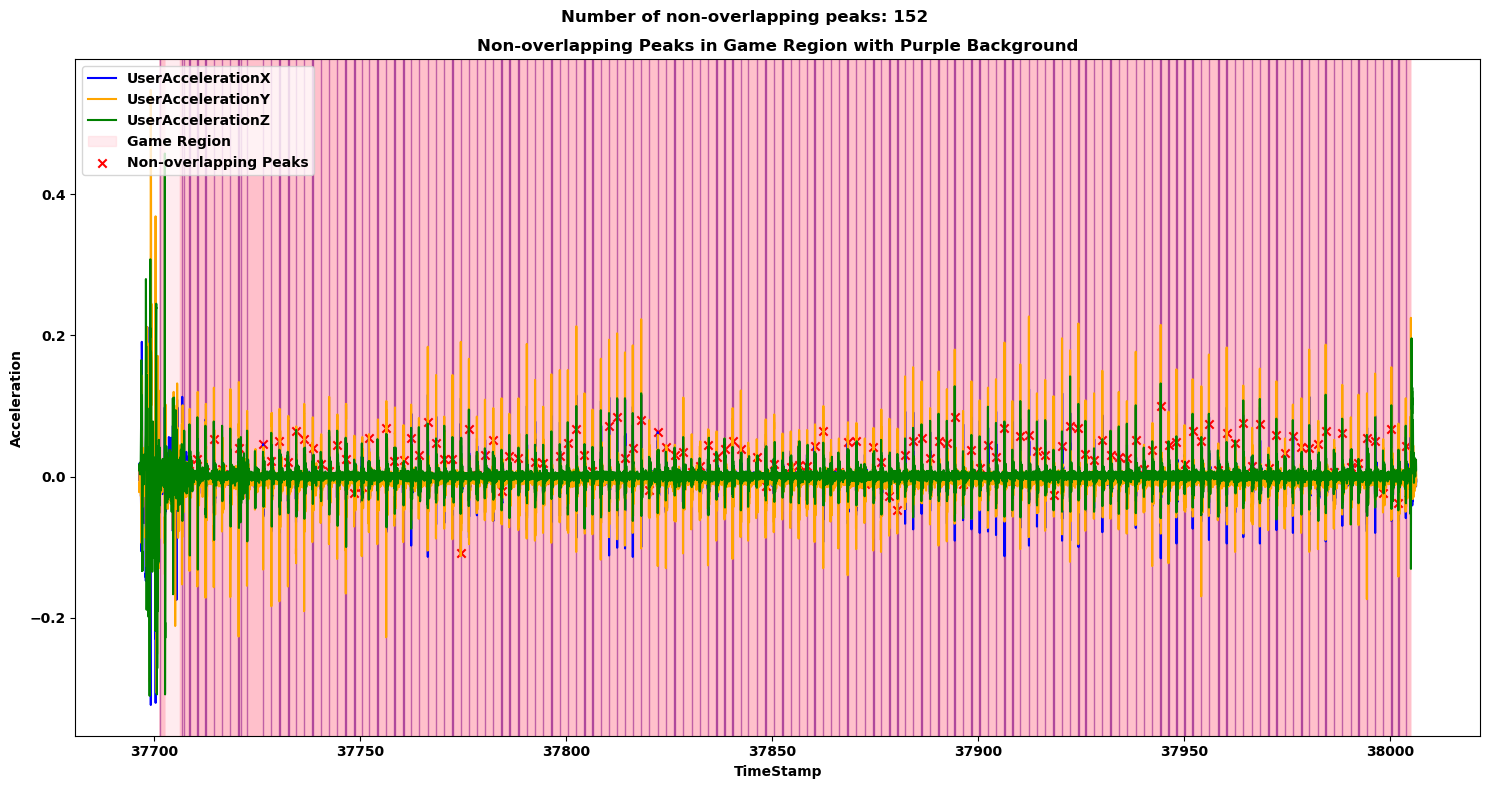

不重疊的峰值數量: 152


In [39]:
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np

# 1. 讀取資料
data = pd.read_csv('data/20241102LeftHandFiveMin_combined.csv')

# 2. 讀取標籤資料，假設標籤資料與主資料具有相同的索引長度
labels = pre

# 3. 將標籤加入到數據中
data['Label'] = labels

# 4. 只取出 'Game' 區域的資料
game_data = data[data['Label'] == 'Game']

# 5. 在 'Game' 區域的每個加速度軸上尋找峰值
peaks_x, _ = find_peaks(game_data['UserAccelerationX'],  height=(0.04, 0.2), distance=50)
peaks_y, _ = find_peaks(game_data['UserAccelerationY'],  height=(0.04, 0.2), distance=50)
peaks_z, _ = find_peaks(game_data['UserAccelerationZ'],  height=(0.04, 0.2), distance=50)

# 6. 將 Game 區域中的峰值的索引轉換為原始數據中的索引
original_peaks_x = game_data.index[peaks_x]
original_peaks_y = game_data.index[peaks_y]
original_peaks_z = game_data.index[peaks_z]

# 7. 合併所有峰值索引
all_peaks = np.concatenate([original_peaks_x, original_peaks_y, original_peaks_z])
all_peaks = np.unique(np.sort(all_peaks))  # 排序並去重

# 8. 去除重疊的峰值，重疊範圍設定為前後10個點
non_overlapping_peaks = [all_peaks[0]]  # 首個峰值一定保留

for peak in all_peaks[1:]:
    if peak - non_overlapping_peaks[-1] > 50:  # 確保相鄰的峰值間隔大於10
        non_overlapping_peaks.append(peak)

# 9. 可視化完整的時序圖，並標記出 Game 區域的不重疊峰值

plt.figure(figsize=(15, 8))

# 繪製 UserAccelerationX, UserAccelerationY, UserAccelerationZ 在同一張圖上
plt.plot(data['TimeStamp'], data['UserAccelerationX'], label="UserAccelerationX", color='blue')
plt.plot(data['TimeStamp'], data['UserAccelerationY'], label="UserAccelerationY", color='orange')
plt.plot(data['TimeStamp'], data['UserAccelerationZ'], label="UserAccelerationZ", color='green')

# 在 Game 區域內塗上粉紅色背景
for start_idx, end_idx in zip(game_data.index[:-1], game_data.index[1:]):
    plt.axvspan(data['TimeStamp'].iloc[start_idx], data['TimeStamp'].iloc[end_idx], color='pink', alpha=0.3, label='Game Region' if start_idx == game_data.index[0] else "")

# 將不重疊峰值區域背景改為紫色
for peak in non_overlapping_peaks:
    plt.axvspan(data['TimeStamp'].iloc[max(0, peak-5)], data['TimeStamp'].iloc[min(len(data)-1, peak+5)], color='purple', alpha=0.5)

# 將 Game 區域內的不重疊峰值標記出來
plt.scatter(data['TimeStamp'].iloc[non_overlapping_peaks], data['UserAccelerationX'].iloc[non_overlapping_peaks], color='red', marker='x', label='Non-overlapping Peaks')

plt.xlabel('TimeStamp')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Non-overlapping Peaks in Game Region with Purple Background')
plt.suptitle(f'Number of non-overlapping peaks: {number_of_non_overlapping_peaks}')
plt.tight_layout()
plt.savefig("peaks.png")
plt.show()

# 10. 打印出不重疊的峰值數量
number_of_non_overlapping_peaks = len(non_overlapping_peaks)
print(f'不重疊的峰值數量: {number_of_non_overlapping_peaks}')


C:\ProgramData\anaconda3\envs\ADHD\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Game 占比: 100.00%


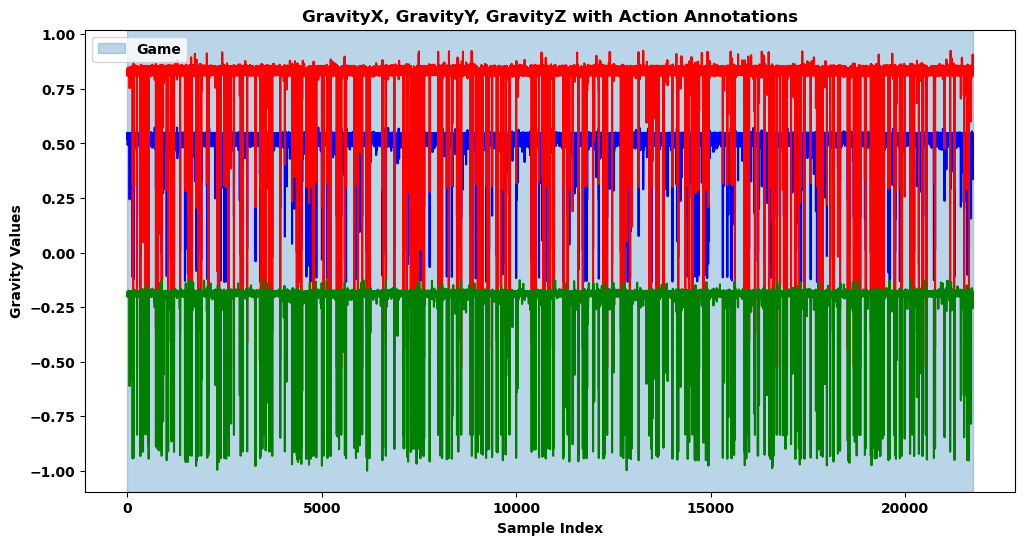

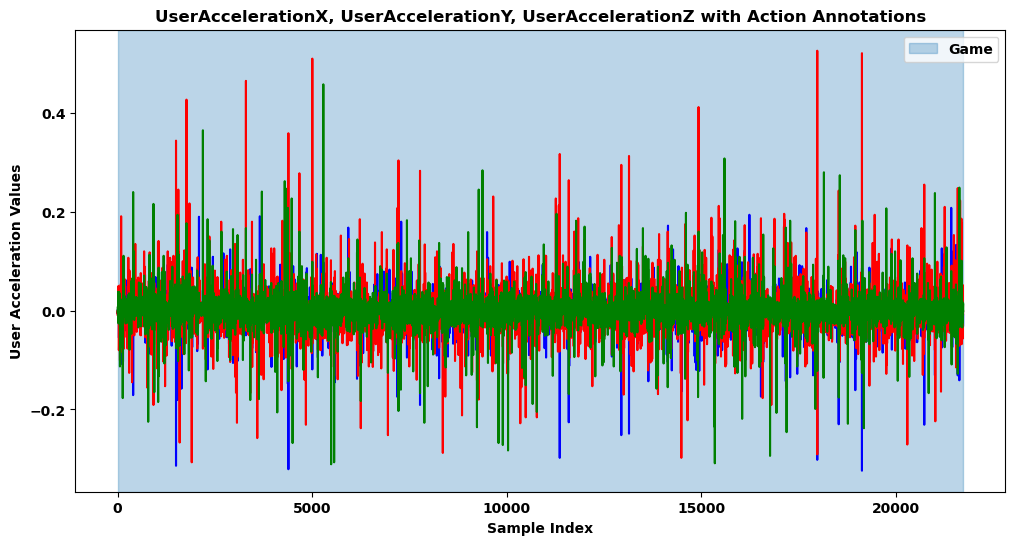

In [5]:
model_dirs = ['saved_models/Game']  # 添加您的動作模型文件夾

file_path = "data/Game/20241102LeftHandFiveMin_combined.csv"
# 調用 detect_action_segments_with_changepoint_voting 函數進行預測
pred = detect_action_segments_with_changepoint_voting(file_path=file_path,
                                                      model_dirs = model_dirs,
                                                      segment_size=100,
                                                      min_action_length=100,
                                                      variables = part_variables,
                                                      smooth_labels=False,
                                                      show_image=True
                                                      )

Game 占比: 100.00%


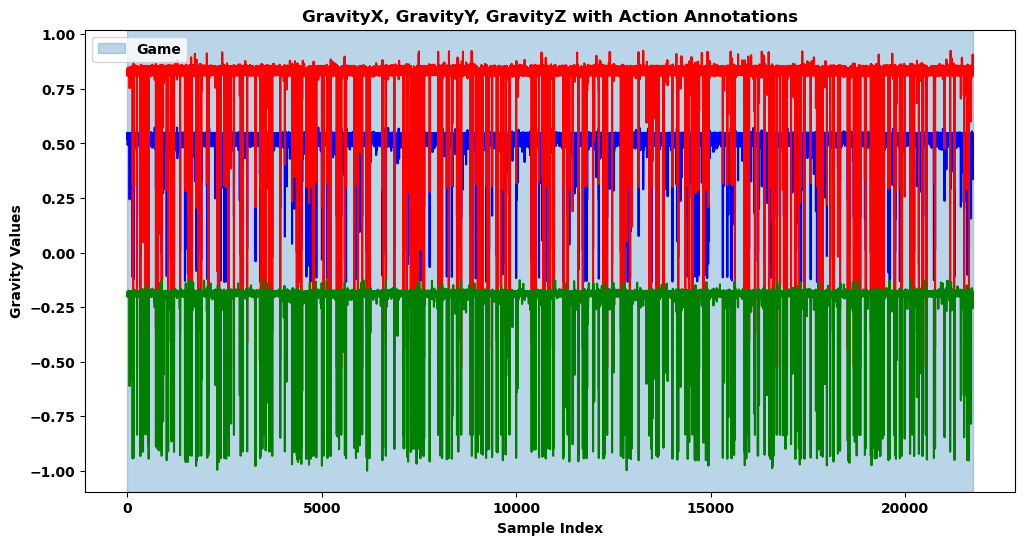

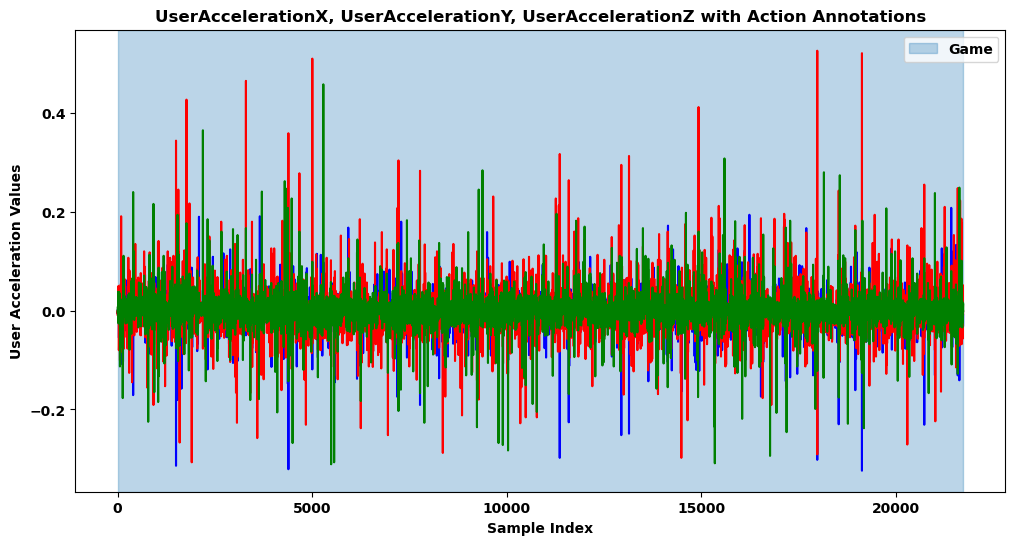

In [41]:
model_dirs = ['saved_models/Game']  # 添加您的動作模型文件夾

file_path = "data/Game/20241102LeftHandFiveMin_combined.csv"
# 調用 detect_action_segments_with_changepoint_voting 函數進行預測
pred = detect_action_segments_with_changepoint_voting(file_path=file_path,
                                                      model_dirs = model_dirs,
                                                      segment_size=100,
                                                      min_action_length=100,
                                                      variables = part_variables,
                                                      smooth_labels=False,
                                                      show_image=True
                                                      )

In [34]:
import pandas as pd
import numpy as np

# 定義要計算的變量列表
all_variables = ['GravityX', 'GravityY', 'GravityZ',
                 'UserAccelerationX', 'UserAccelerationY', 'UserAccelerationZ',
                 'RotationRateX', 'RotationRateY', 'RotationRateZ',
                 'AttitudeRoll', 'AttitudePitch', 'AttitudeYaw']

# 讀取左手數據並添加標簽
left_data = pd.read_csv('data/Game/20241102LeftHandFiveMin_combined.csv')
left_data['label'] = 'LeftHand'

# 讀取右手數據並添加標簽
right_data = pd.read_csv('data/Game/20241102RightHandFiveMin_combined.csv')
right_data['label'] = 'RightHand'

# 檢查數據中是否包含所有指定的變量
missing_vars_left = [var for var in all_variables if var not in left_data.columns]
missing_vars_right = [var for var in all_variables if var not in right_data.columns]

if missing_vars_left:
    print(f"左手數據缺少以下變量：{missing_vars_left}")
if missing_vars_right:
    print(f"右手數據缺少以下變量：{missing_vars_right}")

# 確保所有指定的變量都是數值型
for var in all_variables:
    if left_data[var].dtype == 'object':
        left_data[var] = pd.to_numeric(left_data[var], errors='coerce')
    if right_data[var].dtype == 'object':
        right_data[var] = pd.to_numeric(right_data[var], errors='coerce')

# 定義滑動窗口函數
def sliding_window_features(data, window_size=100, step_size=10, variables=None):
    features = []
    labels = []
    num_windows = (len(data) - window_size) // step_size + 1
    for i in range(0, num_windows * step_size, step_size):
        window = data.iloc[i:i+window_size]
        # 只對指定的變量計算均值和方差
        mean_values = window[variables].mean()
        var_values = window[variables].var()
        # 為索引添加前綴以確保唯一性
        mean_values.index = ['mean_' + col for col in mean_values.index]
        var_values.index = ['var_' + col for col in var_values.index]
        feature_vector = pd.concat([mean_values, var_values])
        features.append(feature_vector)
        labels.append(window['label'].iloc[0])  # 獲取對應的標簽
    features_df = pd.DataFrame(features)
    features_df['label'] = labels
    return features_df

# 對左手數據計算特征
left_features = sliding_window_features(left_data, window_size=100, step_size=10, variables=all_variables)
left_features['label'] = 'LeftHand'

# 對右手數據計算特征
right_features = sliding_window_features(right_data, window_size=100, step_size=10, variables=all_variables)
right_features['label'] = 'RightHand'

# 合並數據集
combined_data = pd.concat([left_features, right_features], ignore_index=True)

# 劃分特征和標簽
X = combined_data.drop(columns=['label'])
y = combined_data['label']

# 訓練CatBoost分類器
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 劃分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化模型
model = CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=0)

# 訓練模型
model.fit(X_train, y_train)

# 評估模型
# 預測
y_pred = model.predict(X_test)

# 計算準確率
accuracy = accuracy_score(y_test, y_pred)
print(f'模型準確率: {accuracy * 100:.2f}%')

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred, labels=['LeftHand', 'RightHand'])
print('混淆矩陣:')
print(conf_matrix)

# 保存特征數據
combined_data.to_csv('combined_features.csv', index=False)


模型準確率: 100.00%
混淆矩陣:
[[456   0]
 [  0 413]]


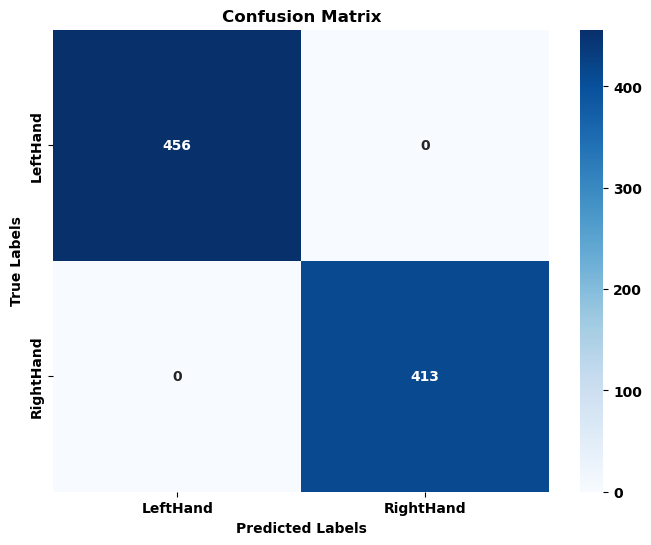

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix data
confusion_matrix = np.array([
    [456, 0],
    [0, 413]
])

# Labels for the classes
labels = ['LeftHand', 'RightHand']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save the plot before showing it
plt.savefig("Game_RightHand_LeftHand_model_confusion_matrix_plot.png")
plt.show()
